<a href="https://colab.research.google.com/github/ananya1331/asteroid_analysis.ipynb/blob/main/AsteroidHazardDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("nasa_asteroids_data.csv")

# View column names
print(df.columns)


FileNotFoundError: [Errno 2] No such file or directory: 'nasa_asteroids_data.csv'

In [1]:
import requests
import pandas as pd
import datetime as dt
import time

# API Key (Replace with your key if available)
API_KEY = "DEMO_KEY"

# Base URL for NASA's API
BASE_URL = "https://api.nasa.gov/neo/rest/v1/feed"

# Function to fetch data for a given date range
def fetch_asteroid_data(start_date, end_date):
    """Fetch asteroid data from NASA API for given date range."""
    params = {
        "start_date": start_date,
        "end_date": end_date,
        "api_key": API_KEY
    }
    response = requests.get(BASE_URL, params=params)

    # Handle errors
    if response.status_code != 200:
        print(f"Error {response.status_code}: {response.json()['error_message']}")
        return None

    return response.json()

# Define start date and number of weeks to fetch
start_date = dt.date(2023, 1, 1)  # Adjust start date as needed
num_weeks = 8  # Fetch data for 8 weeks (~2 months)

# Store results in a list
asteroids_data = []

# Loop through weeks
for i in range(num_weeks):
    end_date = start_date + dt.timedelta(days=6)  # API allows 7-day range
    print(f"Fetching data from {start_date} to {end_date}...")

    data = fetch_asteroid_data(start_date.isoformat(), end_date.isoformat())

    if data and "near_earth_objects" in data:
        for date in data["near_earth_objects"]:
            for asteroid in data["near_earth_objects"][date]:
                asteroids_data.append({
                    "id": asteroid["id"],
                    "name": asteroid["name"],
                    "magnitude": asteroid["absolute_magnitude_h"],
                    "diameter_max": asteroid["estimated_diameter"]["meters"]["estimated_diameter_max"],
                    "hazardous": asteroid["is_potentially_hazardous_asteroid"],
                    "close_approach_date": asteroid["close_approach_data"][0]["close_approach_date"] if asteroid["close_approach_data"] else None,
                    "velocity_km_per_s": asteroid["close_approach_data"][0]["relative_velocity"]["kilometers_per_second"] if asteroid["close_approach_data"] else None
                })

    # Move to the next week
    start_date += dt.timedelta(days=7)

    # Avoid hitting rate limits
    time.sleep(1)  # NASA recommends a 1-second delay per request

# Convert to Pandas DataFrame
df = pd.DataFrame(asteroids_data)

# Save as CSV
df.to_csv("nasa_asteroids_large.csv", index=False)
print(f"Saved {len(df)} asteroid entries to nasa_asteroids_large.csv!")


Fetching data from 2023-01-01 to 2023-01-07...
Fetching data from 2023-01-08 to 2023-01-14...
Fetching data from 2023-01-15 to 2023-01-21...
Fetching data from 2023-01-22 to 2023-01-28...
Fetching data from 2023-01-29 to 2023-02-04...
Fetching data from 2023-02-05 to 2023-02-11...
Fetching data from 2023-02-12 to 2023-02-18...
Fetching data from 2023-02-19 to 2023-02-25...
Saved 986 asteroid entries to nasa_asteroids_large.csv!


In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("nasa_asteroids_large.csv")

# Check the first few rows
print(df.head())

# Check data types and missing values
print(df.info())

# Summary statistics
print(df.describe())


        id               name  magnitude  diameter_max  hazardous  \
0  2385186  385186 (1994 AW1)      17.64   1762.138252       True   
1  2453309  453309 (2008 VQ4)      19.51    744.800533      False   
2  3683468       (2014 QR295)      18.39   1247.498347      False   
3  3703782        (2015 AE45)      25.30     51.765448      False   
4  3720918          (2015 LJ)      24.70     68.240151      False   

  close_approach_date  velocity_km_per_s  
0          2023-01-01          12.924194  
1          2023-01-01           5.822172  
2          2023-01-01          16.180469  
3          2023-01-01           6.862151  
4          2023-01-01           7.189222  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   986 non-null    int64  
 1   name                 986 non-null    object 
 2   magnitude         

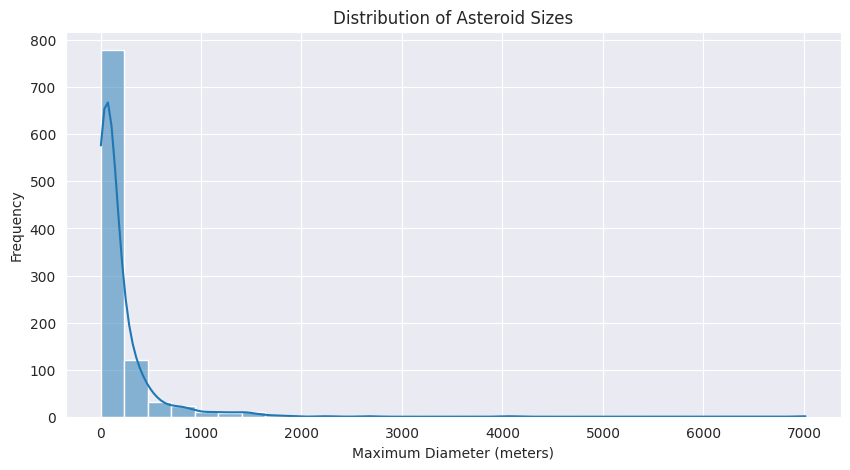

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("darkgrid")

# Plot histogram of asteroid sizes
plt.figure(figsize=(10, 5))
sns.histplot(df["diameter_max"], bins=30, kde=True)
plt.xlabel("Maximum Diameter (meters)")
plt.ylabel("Frequency")
plt.title("Distribution of Asteroid Sizes")
plt.show()


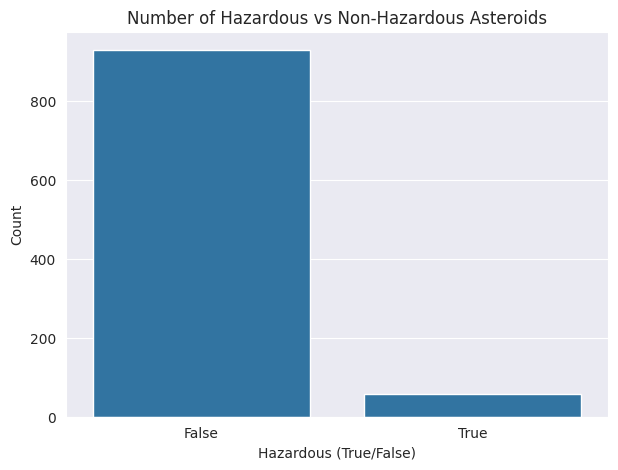

In [4]:
# Count plot of hazardous vs non-hazardous asteroids
plt.figure(figsize=(7, 5))
sns.countplot(x=df["hazardous"])
plt.xlabel("Hazardous (True/False)")
plt.ylabel("Count")
plt.title("Number of Hazardous vs Non-Hazardous Asteroids")
plt.show()


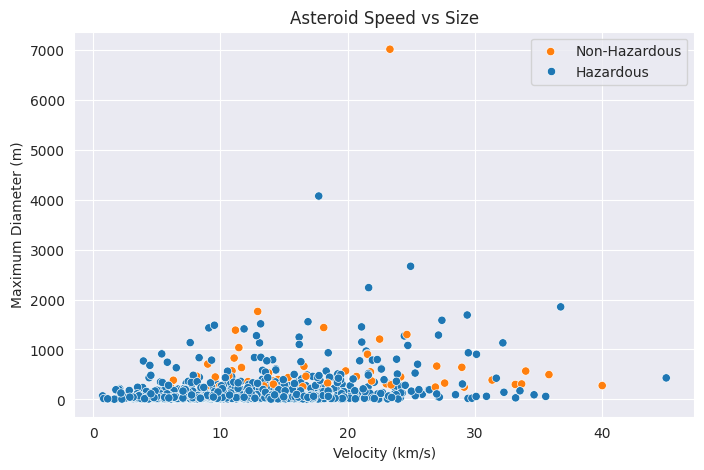

In [5]:
# Scatter plot: Diameter vs Velocity
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["velocity_km_per_s"], y=df["diameter_max"], hue=df["hazardous"])
plt.xlabel("Velocity (km/s)")
plt.ylabel("Maximum Diameter (m)")
plt.title("Asteroid Speed vs Size")
plt.legend(["Non-Hazardous", "Hazardous"])
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features
features = df[["diameter_max", "magnitude", "velocity_km_per_s"]]
target = df["hazardous"].astype(int)  # Convert to 0/1

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9494949494949495
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       188
           1       0.00      0.00      0.00        10

    accuracy                           0.95       198
   macro avg       0.47      0.50      0.49       198
weighted avg       0.90      0.95      0.92       198



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Accuracy: 0.95

Confusion Matrix:
 [[188   0]
 [ 10   0]]

Classification Report:
               precision    recall  f1-score   support

       False       0.95      1.00      0.97       188
        True       0.00      0.00      0.00        10

    accuracy                           0.95       198
   macro avg       0.47      0.50      0.49       198
weighted avg       0.90      0.95      0.92       198



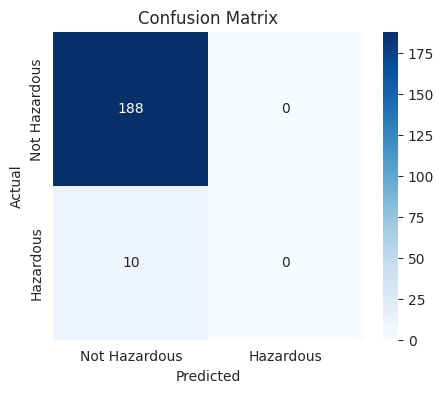

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the dataset
df = pd.read_csv("nasa_asteroids_large.csv")

# Select relevant features for prediction
X = df[['diameter_max', 'magnitude', 'velocity_km_per_s']]
y = df['hazardous']  # Target variable (True/False)

# Standardize the features (important for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print(f"Model Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Visualizing the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [9]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced')

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = LogisticRegression()
model.fit(X_resampled, y_resampled)


LogisticRegression()

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions
y_pred = model.predict(X_test)

# Print Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[159  29]
 [  0  10]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.85      0.92       188
        True       0.26      1.00      0.41        10

    accuracy                           0.85       198
   macro avg       0.63      0.92      0.66       198
weighted avg       0.96      0.85      0.89       198

